# Part 1

## Task 1&2

Import the necessary libraries

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import argparse
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import model_selection
from torchvision import transforms
from torch.utils.data import DataLoader

Use default arguments as shown below

In [2]:
DNN_HIDDEN_UNITS_DEFAULT = '20'
LEARNING_RATE_DEFAULT = 1e-2
MAX_EPOCHS_DEFAULT = 200
EVAL_FREQ_DEFAULT = 40

parser = argparse.ArgumentParser()
parser.add_argument('--dnn_hidden_units', type=str, default=DNN_HIDDEN_UNITS_DEFAULT,
                    help='Comma separated list of number of units in each hidden layer')
parser.add_argument('--learning_rate', type=float, default=LEARNING_RATE_DEFAULT,
                    help='Learning rate')
parser.add_argument('--max_epochs', type=int, default=MAX_EPOCHS_DEFAULT,
                    help='Number of epochs to run trainer.')
parser.add_argument('--eval_freq', type=int, default=EVAL_FREQ_DEFAULT,
                    help='Frequency of evaluation on the test set')
FLAGS, unparsed = parser.parse_known_args()
dnn_hidden_units = FLAGS.dnn_hidden_units
n_hidden = dnn_hidden_units.split(",")
n_hidden = [int(x) for x in n_hidden]
learning_rate = FLAGS.learning_rate
max_epochs = FLAGS.max_epochs
eval_freq = FLAGS.eval_freq

DATASET = None  # denote the current dataset
FRAMEWORK = None  # denote the current framework

Some global methods

In [3]:
def draw(train_loss, test_loss, train_acc, test_acc, epochs):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, color='red', alpha=0.8, linewidth=1, label='Train Loss')
    plt.plot(epochs, test_loss, color='blue', alpha=0.8, linewidth=1, label='Test Loss')
    plt.legend(loc='upper right')
    plt.title(f'Loss Chart {DATASET} {FRAMEWORK}', fontdict={'weight':'normal','size': 8})
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, color='red', alpha=0.8, linewidth=1, label='Train Accuracy')
    plt.plot(epochs, test_acc, color='blue', alpha=0.8, linewidth=1, label='Test Accuracy')
    plt.ylim([0, 1.1])
    plt.legend(loc='lower right')
    plt.title(f'Accuracy Chart {DATASET} {FRAMEWORK}', fontdict={'weight':'normal','size': 8})
    plt.show()


def one_hot(input, num_classes=2):
    return np.eye(num_classes)[input]


def numpy_acc(predictions, targets):
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(targets, axis=1)
    return np.mean(predicted_labels == true_labels)


def pytorch_acc(predictions, targets):
    predictions, targets = predictions.detach().numpy(), targets.detach().numpy()
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(targets, axis=1)
    return np.mean(predicted_labels == true_labels)

Both PyTorch MLP and Numpy MLP use the SGD optimizer.

### MLP Numpy Implementation and Training

In [4]:
class Linear(object):
    def __init__(self, in_features, out_features):
        k = 1 / in_features
        self.params = {'weight': np.random.uniform(-np.sqrt(k), np.sqrt(k), size=(in_features, out_features)),
                       'bias': np.zeros(out_features)}
        self.grads = {'weight': np.zeros_like(self.params['weight']),
                      'bias': np.zeros_like(self.params['bias'])}
        self.x = None

    def forward(self, x):
        out = np.dot(x, self.params['weight']) + self.params['bias']
        self.x = x
        return out

    def backward(self, dout):
        n = dout.shape[0]
        dx = np.dot(dout, self.params['weight'].T)
        self.grads['weight'] = np.dot(self.x.T, dout) / n
        self.grads['bias'] = np.sum(dout, axis=0) / n
        return dx


class ReLU(object):
    def __init__(self):
        self.x = None

    def forward(self, x):
        self.x = x
        out = np.maximum(0, x)
        return out

    def backward(self, dout):
        dx = dout * (self.x > 0)
        return dx


class SoftMax(object):
    def __init__(self):
        self.out = None

    def forward(self, x):
        exp_vals = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.out = exp_vals / np.sum(exp_vals, axis=1, keepdims=True)
        return self.out

    def backward(self, dout):
        dx = -self.out[:, :, None] * self.out[:, None, :]
        dx[:, np.arange(self.out.shape[1]), np.arange(self.out.shape[1])] = self.out * (1 - self.out)
        d_result = np.matmul(dout[:, None, :], dx)
        d_result.resize((d_result.shape[-3], d_result.shape[-1]))
        return d_result


class CrossEntropy(object):
    def __init__(self):
        self.pd = None
        self.gt = None
        self.batch_size = None

    def forward(self, pd, gt):
        self.batch_size = pd.shape[0]
        self.pd = pd
        self.gt = gt
        eps = 1e-9
        loss = - np.sum(np.multiply(gt, np.log(pd + eps))) / self.batch_size
        return loss

    def backward(self):
        eps = 1e-9
        d_loss = - self.gt / (self.pd + eps)
        return d_loss


class NumpyMLP(object):

    def __init__(self, n_inputs, n_hidden, n_classes):
        self.layers = []
        in_features = n_inputs
        for out_features in n_hidden:
            self.layers.append(Linear(in_features, out_features))
            self.layers.append(ReLU())
            in_features = out_features
        self.layers.append(Linear(in_features, n_classes))
        self.layers.append(SoftMax())

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def backward(self, dout):
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

    def update(self, lr):
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.params['weight'] -= lr * layer.grads['weight']
                layer.params['bias'] -= lr * layer.grads['bias']
                layer.grads['weight'] = np.zeros_like(layer.params['weight'])
                layer.grads['bias'] = np.zeros_like(layer.params['bias'])

In [5]:
class NumpySGD(object):
    def __init__(self, mlp):
        self.mlp = mlp

    def optimize(self, inputs, labels, lr, max_epochs, eval_freq):
        x_train, x_test, y_train, y_test = model_selection.train_test_split(inputs, labels, shuffle=True, test_size=0.2)
        y_train, y_test = one_hot(y_train), one_hot(y_test)
        criterion = CrossEntropy()
        train_loss = []
        best_train_loss = 1e5
        train_acc = []
        best_train_acc = 0
        test_loss = []
        best_test_loss = 1e5
        test_acc = []
        best_test_acc = 0
        epochs = []
        n_samples = x_train.shape[0]
        for epoch in range(max_epochs):
            epochs.append(epoch)
            total_loss = 0
            total_acc = 0
            shuffled_indices = np.random.permutation(n_samples)
            for i in range(n_samples):
                idx = shuffled_indices[i]
                x = x_train[idx]
                y = y_train[idx]
                x, y = x[np.newaxis, :], y[np.newaxis, :]
                pd = self.mlp.forward(x)
                loss = criterion.forward(pd, y)
                total_loss += loss
                d_loss = criterion.backward()
                self.mlp.backward(d_loss)
                self.mlp.update(lr)
                acc = numpy_acc(pd, y)
                total_acc += acc
            avg_loss = total_loss / n_samples
            avg_acc = total_acc / n_samples
            train_loss.append(avg_loss)
            train_acc.append(avg_acc)
            if best_train_loss > avg_loss:
                best_train_loss = avg_loss
            if best_train_acc < avg_acc:
                best_train_acc = avg_acc
            pd_test = self.mlp.forward(x_test)
            total_loss = criterion.forward(pd_test, y_test)
            total_acc = numpy_acc(pd_test, y_test)
            test_loss.append(total_loss)
            test_acc.append(total_acc)
            if best_test_loss > total_loss:
                best_test_loss = total_loss
            if best_test_acc < total_acc:
                best_test_acc = total_acc
            if epoch % eval_freq == 0 or epoch == (max_epochs - 1):
                print(f'SGD Epoch {epoch}:')
                print(f'Average Train Loss: {avg_loss} | '
                      f'Average Train Accuracy: {avg_acc}')
                print(f'Average Test Loss: {total_loss} | '
                      f'Average Test Accuracy: {total_acc}')
                print()
        draw(train_loss, test_loss, train_acc, test_acc, epochs)
        print(f'Best Train Loss: {best_train_loss} | '
              f'Best Train Accuracy: {best_train_acc}\n'
              f'Best Test Loss: {best_test_loss} | '
              f'Best Test Accuracy: {best_test_acc}')


def numpy_train(inputs, labels):
    mlp = NumpyMLP(2, n_hidden, 2)
    optimizer = NumpySGD(mlp)
    optimizer.optimize(inputs, labels, learning_rate, max_epochs, eval_freq)

### MLP PyTorch Implementation and Training

In [6]:
class PyTorchMLP(nn.Module):

    def __init__(self, n_inputs, n_hidden, n_classes):
        super(PyTorchMLP, self).__init__()
        self.layers = nn.Sequential()
        in_features = n_inputs
        for (i, out_features) in enumerate(n_hidden):
            self.layers.add_module('linear' + str(i), nn.Linear(in_features, out_features))
            self.layers.add_module('relu' + str(i), nn.ReLU())
            in_features = out_features
        self.layers.add_module('linear' + str(len(n_hidden)), nn.Linear(in_features, n_classes))

    def forward(self, x):
        out = self.layers(x)
        return out


pytorch_mlp = PyTorchMLP(2, n_hidden, 2)
pytorch_mlp

PyTorchMLP(
  (layers): Sequential(
    (linear0): Linear(in_features=2, out_features=20, bias=True)
    (relu0): ReLU()
    (linear1): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [7]:
def pytorch_train(inputs, labels):
    mlp = PyTorchMLP(2, n_hidden, 2)
    criterion = nn.CrossEntropyLoss()
    x_train, x_test, y_train, y_test = model_selection.train_test_split(inputs, labels, shuffle=True, test_size=0.2)
    y_train, y_test = one_hot(y_train), one_hot(y_test)
    x_test, y_test = torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float()
    train_loss = []
    best_train_loss = 1e5
    train_acc = []
    best_train_acc = 0
    test_loss = []
    best_test_loss = 1e5
    test_acc = []
    best_test_acc = 0
    epochs = []
    n_samples = x_train.shape[0]
    for epoch in range(max_epochs):
        epochs.append(epoch)
        total_loss = 0
        total_acc = 0
        shuffled_indices = np.random.permutation(n_samples)
        for i in range(n_samples):
            idx = shuffled_indices[i]
            x = x_train[idx]
            y = y_train[idx]
            x, y = x[np.newaxis, :], y[np.newaxis, :]
            x, y = torch.from_numpy(x).float(), torch.from_numpy(y).float()
            pd = mlp(x)
            loss = criterion(pd, y)
            total_loss += loss
            mlp.zero_grad()
            loss.backward()
            for f in mlp.parameters():
                f.data.sub_(f.grad.data * learning_rate)
            acc = pytorch_acc(pd, y)
            total_acc += acc
        avg_loss = total_loss / n_samples
        avg_acc = total_acc / n_samples
        train_loss.append(avg_loss.detach().numpy())
        train_acc.append(avg_acc)
        if best_train_loss > avg_loss:
            best_train_loss = avg_loss
        if best_train_acc < avg_acc:
            best_train_acc = avg_acc
        pd_test = mlp(x_test)
        with torch.no_grad():
            loss_test = criterion(pd_test, y_test)
            acc_test = pytorch_acc(pd_test, y_test)
        test_loss.append(loss_test.detach().numpy())
        test_acc.append(acc_test)
        if best_test_loss > loss_test:
            best_test_loss = loss_test
        if best_test_acc < acc_test:
            best_test_acc = acc_test
        if epoch % eval_freq == 0 or epoch == (max_epochs - 1):
            print(f'SGD Epoch {epoch}:')
            print(f'Average Train Loss: {avg_loss} | '
                  f'Average Train Accuracy: {avg_acc}')
            print(f'Average Test Loss: {loss_test} | '
                  f'Average Test Accuracy: {acc_test}')
            print()
    draw(train_loss, test_loss, train_acc, test_acc, epochs)
    print(f'Best Train Loss: {best_train_loss} | '
          f'Best Train Accuracy: {best_train_acc}\n'
          f'Best Test Loss: {best_test_loss} | '
          f'Best Test Accuracy: {best_test_acc}')

### make_moons dataset

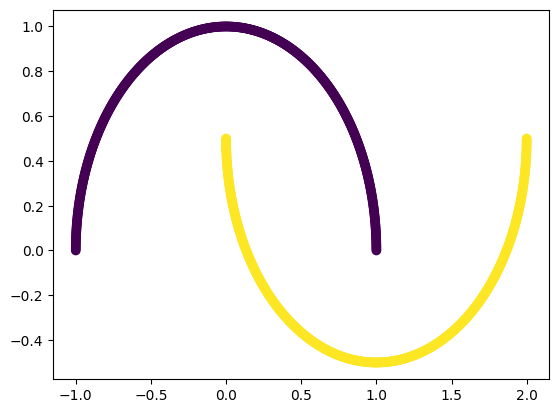

In [8]:
inputs, labels = datasets.make_moons(n_samples=1000, shuffle=True)
plt.scatter(inputs[:, 0], inputs[:, 1], c=labels)
plt.show()
DATASET = "moons"

SGD Epoch 0:
Average Train Loss: 0.3719298144823714 | Average Train Accuracy: 0.84
Average Test Loss: 0.2933044605294045 | Average Test Accuracy: 0.855

SGD Epoch 40:
Average Train Loss: 0.008089377698839887 | Average Train Accuracy: 1.0
Average Test Loss: 0.008471399137188257 | Average Test Accuracy: 1.0

SGD Epoch 80:
Average Train Loss: 0.002758009660743689 | Average Train Accuracy: 1.0
Average Test Loss: 0.002940851750078023 | Average Test Accuracy: 1.0

SGD Epoch 120:
Average Train Loss: 0.0015850267855487235 | Average Train Accuracy: 1.0
Average Test Loss: 0.0016984141464052803 | Average Test Accuracy: 1.0

SGD Epoch 160:
Average Train Loss: 0.0010913521575490037 | Average Train Accuracy: 1.0
Average Test Loss: 0.0011871034323700197 | Average Test Accuracy: 1.0

SGD Epoch 199:
Average Train Loss: 0.0008298629278206548 | Average Train Accuracy: 1.0
Average Test Loss: 0.0009102350629405885 | Average Test Accuracy: 1.0



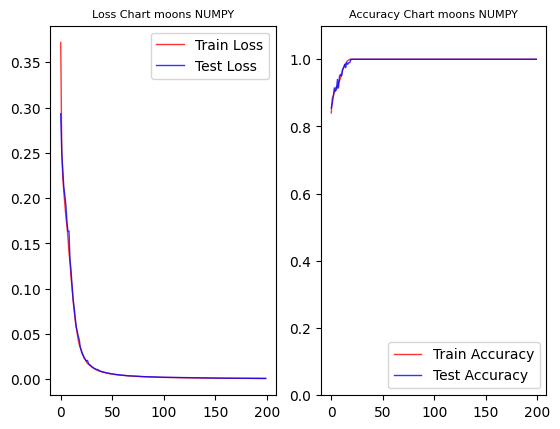

Best Train Loss: 0.0008298629278206548 | Best Train Accuracy: 1.0
Best Test Loss: 0.0009102350629405885 | Best Test Accuracy: 1.0


In [9]:
FRAMEWORK = "NUMPY"
numpy_train(inputs, labels)

SGD Epoch 0:
Average Train Loss: 0.3785879611968994 | Average Train Accuracy: 0.8475
Average Test Loss: 0.27407553791999817 | Average Test Accuracy: 0.875

SGD Epoch 40:
Average Train Loss: 0.0060523562133312225 | Average Train Accuracy: 1.0
Average Test Loss: 0.005284386686980724 | Average Test Accuracy: 1.0

SGD Epoch 80:
Average Train Loss: 0.0021823514252901077 | Average Train Accuracy: 1.0
Average Test Loss: 0.0018738254439085722 | Average Test Accuracy: 1.0

SGD Epoch 120:
Average Train Loss: 0.0012723281979560852 | Average Train Accuracy: 1.0
Average Test Loss: 0.0010898143518716097 | Average Test Accuracy: 1.0

SGD Epoch 160:
Average Train Loss: 0.0008812767337076366 | Average Train Accuracy: 1.0
Average Test Loss: 0.0007546330452896655 | Average Test Accuracy: 1.0

SGD Epoch 199:
Average Train Loss: 0.0006725723505951464 | Average Train Accuracy: 1.0
Average Test Loss: 0.0005744317313656211 | Average Test Accuracy: 1.0



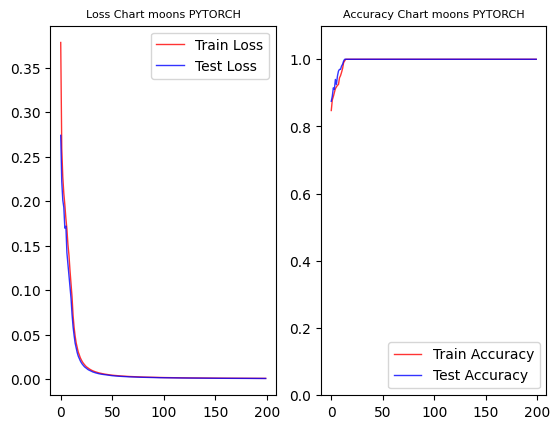

Best Train Loss: 0.0006725723505951464 | Best Train Accuracy: 1.0
Best Test Loss: 0.0005744317313656211 | Best Test Accuracy: 1.0


In [10]:
FRAMEWORK = "PYTORCH"
pytorch_train(inputs, labels)

### make_blobs dataset

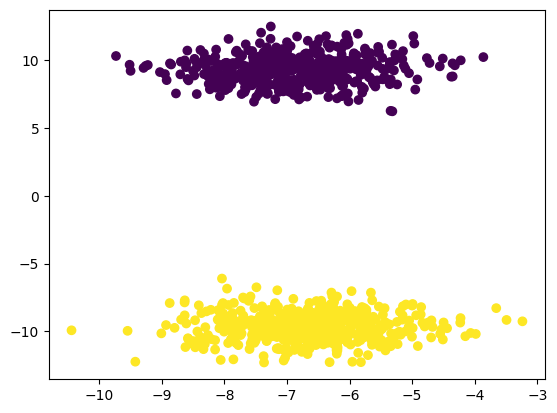

In [11]:
inputs, labels = datasets.make_blobs(n_samples=1000, centers=2, n_features=2)
plt.scatter(inputs[:, 0], inputs[:, 1], c=labels)
plt.show()
DATASET = "blobs"

SGD Epoch 0:
Average Train Loss: 0.0018897718183546615 | Average Train Accuracy: 1.0
Average Test Loss: 0.0004516992956648647 | Average Test Accuracy: 1.0

SGD Epoch 40:
Average Train Loss: 1.253801184723641e-05 | Average Train Accuracy: 1.0
Average Test Loss: 1.1727658993337538e-05 | Average Test Accuracy: 1.0

SGD Epoch 80:
Average Train Loss: 6.232625788364318e-06 | Average Train Accuracy: 1.0
Average Test Loss: 5.849153950994355e-06 | Average Test Accuracy: 1.0

SGD Epoch 120:
Average Train Loss: 4.131346462952181e-06 | Average Train Accuracy: 1.0
Average Test Loss: 3.881733181164156e-06 | Average Test Accuracy: 1.0

SGD Epoch 160:
Average Train Loss: 3.0836076623684158e-06 | Average Train Accuracy: 1.0
Average Test Loss: 2.8996688618687792e-06 | Average Test Accuracy: 1.0

SGD Epoch 199:
Average Train Loss: 2.4694811967319023e-06 | Average Train Accuracy: 1.0
Average Test Loss: 2.3237849794853655e-06 | Average Test Accuracy: 1.0



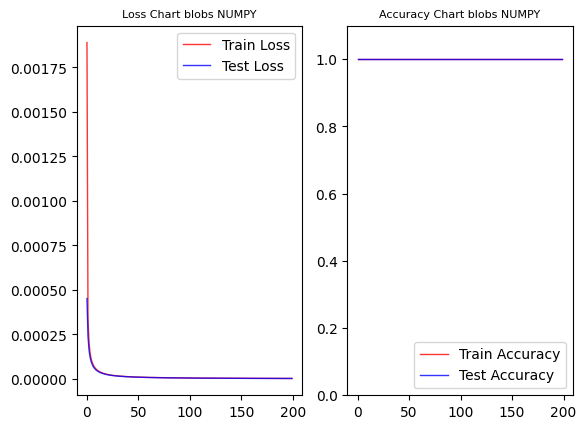

Best Train Loss: 2.4694811967319023e-06 | Best Train Accuracy: 1.0
Best Test Loss: 2.3237849794853655e-06 | Best Test Accuracy: 1.0


In [12]:
FRAMEWORK = "NUMPY"
numpy_train(inputs, labels)

SGD Epoch 0:
Average Train Loss: 0.005400040186941624 | Average Train Accuracy: 0.99875
Average Test Loss: 0.0006236682529561222 | Average Test Accuracy: 1.0

SGD Epoch 40:
Average Train Loss: 1.3443022908177227e-05 | Average Train Accuracy: 1.0
Average Test Loss: 1.4979317711549811e-05 | Average Test Accuracy: 1.0

SGD Epoch 80:
Average Train Loss: 6.617953204113292e-06 | Average Train Accuracy: 1.0
Average Test Loss: 7.588705557282083e-06 | Average Test Accuracy: 1.0

SGD Epoch 120:
Average Train Loss: 4.364206233731238e-06 | Average Train Accuracy: 1.0
Average Test Loss: 5.093735126138199e-06 | Average Test Accuracy: 1.0

SGD Epoch 160:
Average Train Loss: 3.2463403840665706e-06 | Average Train Accuracy: 1.0
Average Test Loss: 3.835511506622424e-06 | Average Test Accuracy: 1.0

SGD Epoch 199:
Average Train Loss: 2.5953168005798943e-06 | Average Train Accuracy: 1.0
Average Test Loss: 3.092852466579643e-06 | Average Test Accuracy: 1.0



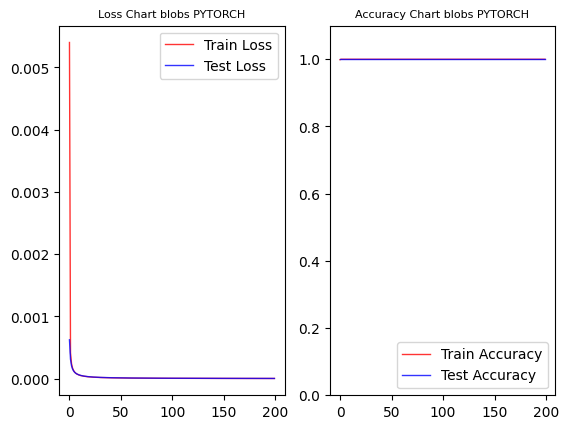

Best Train Loss: 2.5953168005798943e-06 | Best Train Accuracy: 1.0
Best Test Loss: 3.092852466579643e-06 | Best Test Accuracy: 1.0


In [13]:
FRAMEWORK = "PYTORCH"
pytorch_train(inputs, labels)

### make_circles dataset

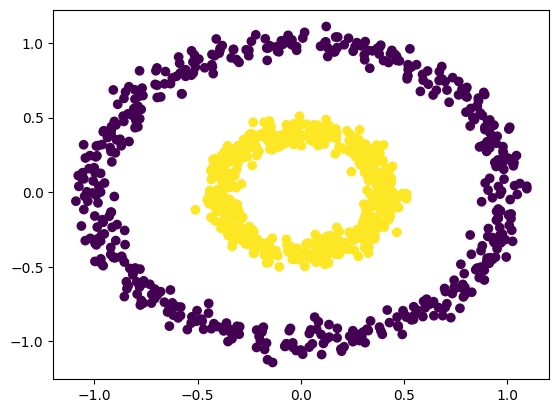

In [14]:
inputs, labels = datasets.make_circles(n_samples=1000, factor=0.4, noise=0.05)
plt.scatter(inputs[:, 0], inputs[:, 1], c=labels)
plt.show()
DATASET = "circles"

SGD Epoch 0:
Average Train Loss: 0.6299879277930301 | Average Train Accuracy: 0.6625
Average Test Loss: 0.5495707778703349 | Average Test Accuracy: 0.935

SGD Epoch 40:
Average Train Loss: 0.007927860146189594 | Average Train Accuracy: 1.0
Average Test Loss: 0.007515641638149795 | Average Test Accuracy: 1.0

SGD Epoch 80:
Average Train Loss: 0.0034358253186707144 | Average Train Accuracy: 1.0
Average Test Loss: 0.003287308547227337 | Average Test Accuracy: 1.0

SGD Epoch 120:
Average Train Loss: 0.0021533530666012343 | Average Train Accuracy: 1.0
Average Test Loss: 0.0020706164310241525 | Average Test Accuracy: 1.0

SGD Epoch 160:
Average Train Loss: 0.0015566008021002714 | Average Train Accuracy: 1.0
Average Test Loss: 0.001500440288456692 | Average Test Accuracy: 1.0

SGD Epoch 199:
Average Train Loss: 0.0012208813533739259 | Average Train Accuracy: 1.0
Average Test Loss: 0.0011772783378801274 | Average Test Accuracy: 1.0



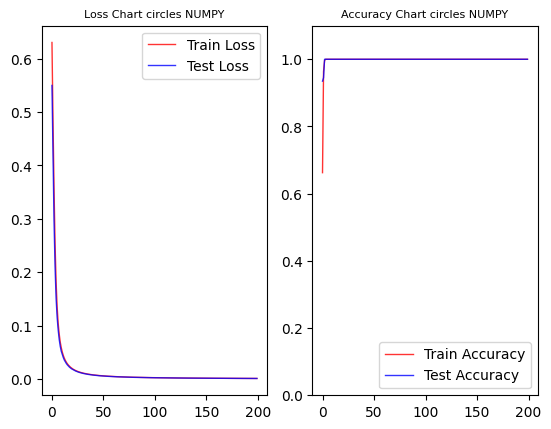

Best Train Loss: 0.0012208813533739259 | Best Train Accuracy: 1.0
Best Test Loss: 0.0011772783378801274 | Best Test Accuracy: 1.0


In [15]:
FRAMEWORK = "NUMPY"
numpy_train(inputs, labels)

SGD Epoch 0:
Average Train Loss: 0.6389740109443665 | Average Train Accuracy: 0.67375
Average Test Loss: 0.6052425503730774 | Average Test Accuracy: 0.665

SGD Epoch 40:
Average Train Loss: 0.004631287418305874 | Average Train Accuracy: 1.0
Average Test Loss: 0.004072312265634537 | Average Test Accuracy: 1.0

SGD Epoch 80:
Average Train Loss: 0.001933015533722937 | Average Train Accuracy: 1.0
Average Test Loss: 0.0016458051977679133 | Average Test Accuracy: 1.0

SGD Epoch 120:
Average Train Loss: 0.0011895872885361314 | Average Train Accuracy: 1.0
Average Test Loss: 0.0009886743500828743 | Average Test Accuracy: 1.0

SGD Epoch 160:
Average Train Loss: 0.0008497959934175014 | Average Train Accuracy: 1.0
Average Test Loss: 0.0006950797978788614 | Average Test Accuracy: 1.0

SGD Epoch 199:
Average Train Loss: 0.0006609730189666152 | Average Train Accuracy: 1.0
Average Test Loss: 0.0005348223494365811 | Average Test Accuracy: 1.0



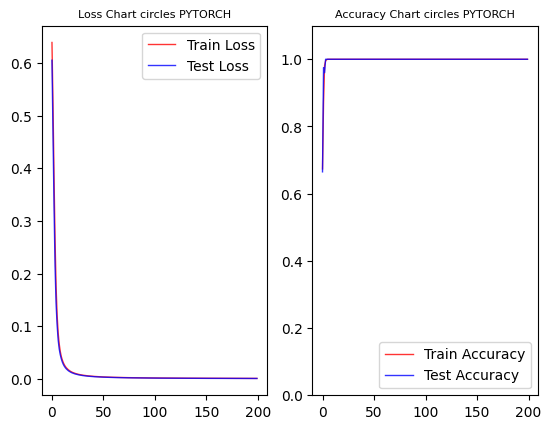

Best Train Loss: 0.0006609730189666152 | Best Train Accuracy: 1.0
Best Test Loss: 0.0005348223494365811 | Best Test Accuracy: 1.0


In [16]:
FRAMEWORK = "PYTORCH"
pytorch_train(inputs, labels)

### make_classification dataset

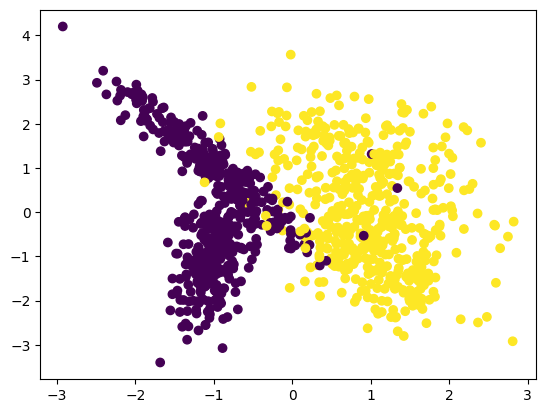

In [17]:
inputs, labels = datasets.make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                                              n_repeated=0, hypercube=True)
plt.scatter(inputs[:, 0], inputs[:, 1], c=labels)
plt.show()
DATASET = "classification"

SGD Epoch 0:
Average Train Loss: 0.26220999082886104 | Average Train Accuracy: 0.94875
Average Test Loss: 0.12164281037764244 | Average Test Accuracy: 0.975

SGD Epoch 40:
Average Train Loss: 0.0845688339369296 | Average Train Accuracy: 0.97625
Average Test Loss: 0.08452599543953408 | Average Test Accuracy: 0.975

SGD Epoch 80:
Average Train Loss: 0.08209323341367311 | Average Train Accuracy: 0.97125
Average Test Loss: 0.08297062728515141 | Average Test Accuracy: 0.975

SGD Epoch 120:
Average Train Loss: 0.0809786337386276 | Average Train Accuracy: 0.9775
Average Test Loss: 0.09133954712947233 | Average Test Accuracy: 0.975

SGD Epoch 160:
Average Train Loss: 0.07956255821709204 | Average Train Accuracy: 0.9775
Average Test Loss: 0.08767695057692915 | Average Test Accuracy: 0.98

SGD Epoch 199:
Average Train Loss: 0.0790571905273088 | Average Train Accuracy: 0.97625
Average Test Loss: 0.0940700464549425 | Average Test Accuracy: 0.975



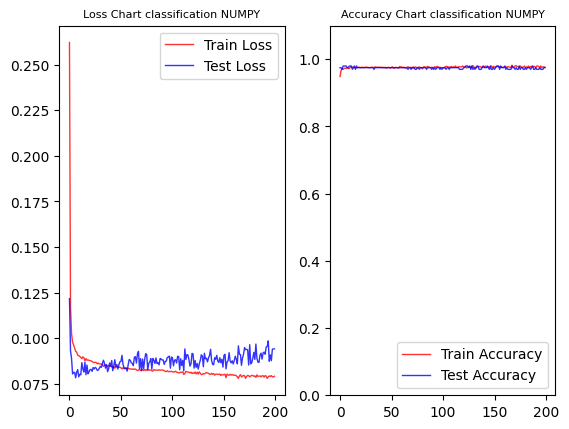

Best Train Loss: 0.07784277106537366 | Best Train Accuracy: 0.9825
Best Test Loss: 0.07820621669268285 | Best Test Accuracy: 0.98


In [18]:
FRAMEWORK = "NUMPY"
numpy_train(inputs, labels)

SGD Epoch 0:
Average Train Loss: 0.26082754135131836 | Average Train Accuracy: 0.93125
Average Test Loss: 0.11507034301757812 | Average Test Accuracy: 0.97

SGD Epoch 40:
Average Train Loss: 0.08474588394165039 | Average Train Accuracy: 0.975
Average Test Loss: 0.08517061918973923 | Average Test Accuracy: 0.975

SGD Epoch 80:
Average Train Loss: 0.08254282176494598 | Average Train Accuracy: 0.97875
Average Test Loss: 0.08686026930809021 | Average Test Accuracy: 0.975

SGD Epoch 120:
Average Train Loss: 0.08020398765802383 | Average Train Accuracy: 0.97625
Average Test Loss: 0.08620160818099976 | Average Test Accuracy: 0.975

SGD Epoch 160:
Average Train Loss: 0.0776338055729866 | Average Train Accuracy: 0.9775
Average Test Loss: 0.08601728081703186 | Average Test Accuracy: 0.97

SGD Epoch 199:
Average Train Loss: 0.076995350420475 | Average Train Accuracy: 0.97875
Average Test Loss: 0.08666889369487762 | Average Test Accuracy: 0.975



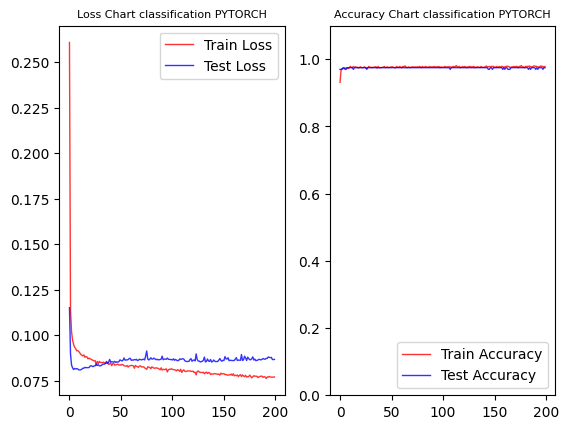

Best Train Loss: 0.0761747807264328 | Best Train Accuracy: 0.98125
Best Test Loss: 0.0808667466044426 | Best Test Accuracy: 0.975


In [19]:
FRAMEWORK = "PYTORCH"
pytorch_train(inputs, labels)

## Task 3

In [20]:
batch_size = 512
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)
test_dataset = torchvision.datasets.CIFAR10(root='data', train=False, download=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


In [21]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [22]:
cuda_id = 0
device_name = "cuda:{}".format(cuda_id) if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

input_size = 3072
hidden_size = 512
num_classes = 10
model = MLP(input_size, hidden_size, num_classes)
model = model.to(device)
model

MLP(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)

In [23]:
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    for images, labels in loader:
        images = images.reshape(-1, input_size)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {:.2f} %'.format(total, 100 * correct / total))
    return 100 * correct / total

Epoch [1/100], Loss: 1.6620, Accuracy: 40.84%
Test Accuracy of the model on the 10000 test images: 47.59 %
Epoch [2/100], Loss: 1.4237, Accuracy: 49.88%
Test Accuracy of the model on the 10000 test images: 50.26 %
Epoch [3/100], Loss: 1.2984, Accuracy: 54.14%
Test Accuracy of the model on the 10000 test images: 51.93 %
Epoch [4/100], Loss: 1.2013, Accuracy: 57.76%
Test Accuracy of the model on the 10000 test images: 52.39 %
Epoch [5/100], Loss: 1.1112, Accuracy: 60.78%
Test Accuracy of the model on the 10000 test images: 54.01 %
Epoch [6/100], Loss: 1.0240, Accuracy: 63.90%
Test Accuracy of the model on the 10000 test images: 53.85 %
Epoch [7/100], Loss: 0.9365, Accuracy: 66.85%
Test Accuracy of the model on the 10000 test images: 53.89 %
Epoch [8/100], Loss: 0.8561, Accuracy: 69.64%
Test Accuracy of the model on the 10000 test images: 54.89 %
Epoch [9/100], Loss: 0.7772, Accuracy: 72.71%
Test Accuracy of the model on the 10000 test images: 55.31 %
Epoch [10/100], Loss: 0.6948, Accurac

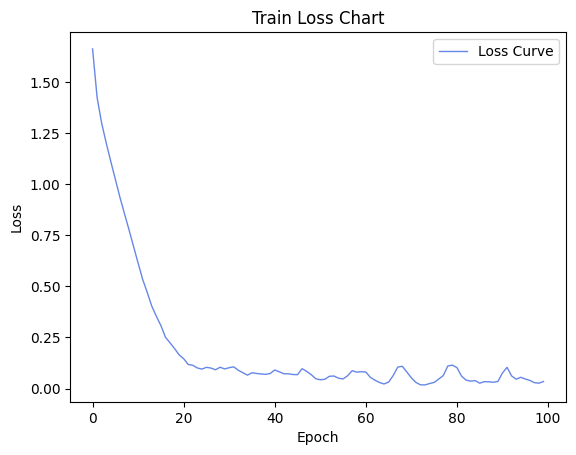

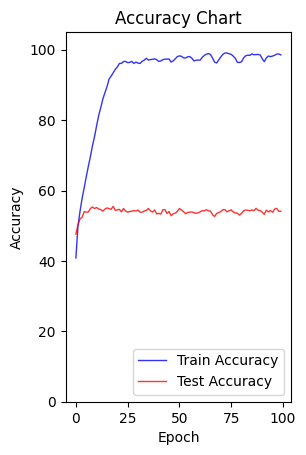

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
losses = []
train_accs = []
test_accs = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, input_size)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        total_loss += loss.item()
        total_correct += correct
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(total_loss / len(train_loader))
    acc = total_correct / (batch_size * len(train_loader)) * 100
    train_accs.append(acc)
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
          .format(epoch + 1, epochs, total_loss / len(train_loader), acc))
    test_acc = test(model, test_loader)
    test_accs.append(test_acc)

plt.plot([i for i in range(epochs)], losses, '-', color='#4169E1', alpha=0.8, linewidth=1, label="Loss Curve")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss Chart")
plt.show()

plt.figure()
plt.subplot(1, 2, 1)
plt.plot([i for i in range(epochs)], train_accs, '-', color='blue', alpha=0.8, linewidth=1, label="Train Accuracy")
plt.legend(loc="lower right")
plt.plot([i for i in range(epochs)], test_accs, '-', color='red', alpha=0.8, linewidth=1, label="Test Accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 105])
plt.title("Accuracy Chart")
plt.show()